# SETUP KAGGLE API AND DOWNLOAD DATASET



In [ ]:
# Create the .kaggle directory and copy the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Download the cataract dataset from Kaggle
!kaggle datasets download -d jr2ngb/cataractdataset

# Unzip the downloaded dataset
!unzip cataractdataset.zip -d /content/


Dataset URL: https://www.kaggle.com/datasets/jr2ngb/cataractdataset
License(s): unknown
100% 3.34G/3.34G [00:53<00:00, 64.5MB/s]
100% 3.34G/3.34G [00:53<00:00, 66.5MB/s]
Archive:  cataractdataset.zip
  inflating: /content/README.md      
  inflating: /content/dataset/1_normal/NL_001.png  
  inflating: /content/dataset/1_normal/NL_002.png  
  inflating: /content/dataset/1_normal/NL_003.png  
  inflating: /content/dataset/1_normal/NL_004.png  
  inflating: /content/dataset/1_normal/NL_005.png  
  inflating: /content/dataset/1_normal/NL_006.png  
  inflating: /content/dataset/1_normal/NL_007.png  
  inflating: /content/dataset/1_normal/NL_008.png  
  inflating: /content/dataset/1_normal/NL_009.png  
  inflating: /content/dataset/1_normal/NL_010.png  
  inflating: /content/dataset/1_normal/NL_011.png  
  inflating: /content/dataset/1_normal/NL_012.png  
  inflating: /content/dataset/1_normal/NL_013.png  
  inflating: /content/dataset/1_normal/NL_014.png  
  inflating: /content/dataset/1_no

# REMOVE UNNECESSARY DIRECTORIES

In [ ]:
#to remove unnecessary datasets
# Define the path to the folder containing the classes
path = '/content/repository/yiweichen04-retina_dataset-914b0f4/dataset'

# List all directories and store them in a Python list
dirs = !ls -d $path/*/

# Convert the paths to a list of strings
dirs = [d.strip() for d in dirs]

# Print the directories to be removed
print(f"Directories to be removed: {dirs[-2]}, {dirs[-1]}")

# Remove the last two directories
!rm -r {dirs[-2]}
!rm -r {dirs[-1]}

# Verify the removal
!ls $path

Directories to be removed: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_glaucoma/, /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/3_retina_disease/
/bin/bash: line 1: ls /content/repository/yiweichen04-retina_dataset-914b0f4/dataset: No such file or directory


# CHECK NUMBER OF IMAGES

In [ ]:
import os
import shutil
dataset_path = '/content/repository/yiweichen04-retina_dataset-914b0f4/dataset'
for dirpath, dirname, filename in os.walk(dataset_path):
    print(f"Directory: {dirpath}, Subdirectories: {len(dirname)}, Files: {len(filename)}")

Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset, Subdirectories: 2, Files: 0
Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/1_normal, Subdirectories: 0, Files: 300
Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_cataract, Subdirectories: 0, Files: 100


# VISUALIZE IMAGES

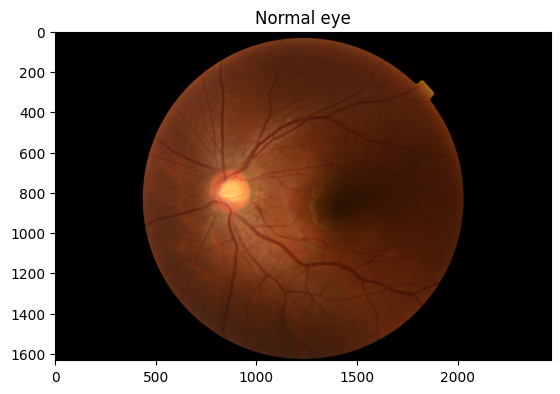

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

def img_show(img_path, title):
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)
    plt.title(title)
    plt.show()

img_show('/content/repository/yiweichen04-retina_dataset-914b0f4/dataset/1_normal/NL_001.png', 'Normal eye')


# DATA AUGMENTATION

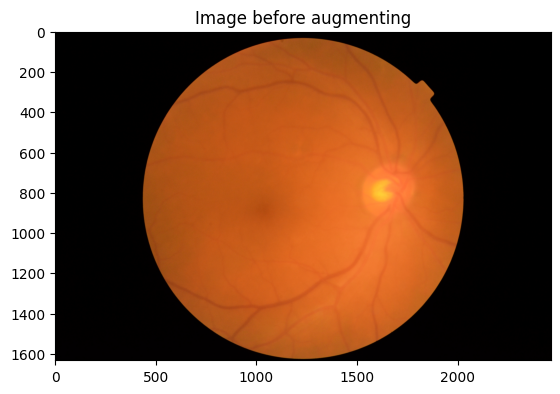

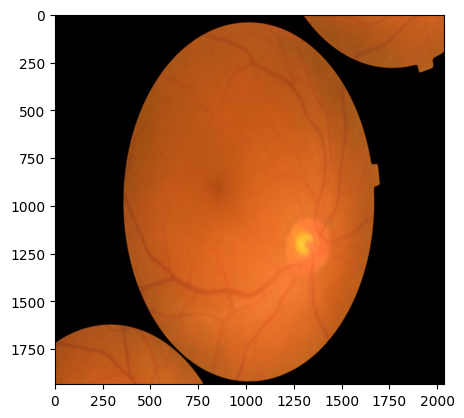

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

# Test the augmentation layer
path = "/content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_cataract/cataract_075.png"
img_show(path, "Image before augmenting")
img = cv2.imread(path)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze((augmented_img)/255.)[:, :, ::-1]

plt.figure()
plt.imshow(augmented_img)
plt.show()


# SPLIT DATA

In [ ]:
import os
import shutil

# Define paths for train, validation, and test folders
base_path = "/content/repository/yiweichen04-retina_dataset-914b0f4"
original_folder = os.path.join(base_path, "dataset")
train_folder = os.path.join(base_path, "train")
validation_folder = os.path.join(base_path, "validation")
test_folder = os.path.join(base_path, "test")

# Create directories
for folder in [train_folder, validation_folder, test_folder]:
    os.makedirs(os.path.join(folder, "normal"), exist_ok=True)
    os.makedirs(os.path.join(folder, "cataract"), exist_ok=True)

def copy_files(start, stop, src_folder, dst_folder, prefix):
    for i in range(start, stop+1):
        filename = f"{prefix}_{i:03}.png"
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.copy(src_path, dst_path)

# Training set (240 normal, 80 cataract)
copy_files(1, 240, os.path.join(original_folder, "1_normal"), os.path.join(train_folder, "normal"), "NL")
copy_files(1, 80, os.path.join(original_folder, "2_cataract"), os.path.join(train_folder, "cataract"), "cataract")

# Validation set (30 normal, 10 cataract)
copy_files(241, 270, os.path.join(original_folder, "1_normal"), os.path.join(validation_folder, "normal"), "NL")
copy_files(81, 90, os.path.join(original_folder, "2_cataract"), os.path.join(validation_folder, "cataract"), "cataract")

# Test set (30 normal, 10 cataract)
copy_files(271, 300, os.path.join(original_folder, "1_normal"), os.path.join(test_folder, "normal"), "NL")
copy_files(91, 100, os.path.join(original_folder, "2_cataract"), os.path.join(test_folder, "cataract"), "cataract")


# DATA PREPROCESSING

In [ ]:
import tensorflow as tf

train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "validation")

img_size = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=32
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=32
)

print(train_data.class_names)


Found 320 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
['cataract', 'normal']


# MODEL BUILDING

In [ ]:
# UPDATED CODE
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define directories and parameters
train_dir = '/content/repository/yiweichen04-retina_dataset-914b0f4/train'
val_dir = '/content/repository/yiweichen04-retina_dataset-914b0f4/validation'
test_dir = '/content/repository/yiweichen04-retina_dataset-914b0f4/test'
batch_size = 32
img_size = (299, 299)
epochs = 50  # Define the number of epochs for training

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# InceptionV3 model
inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))
x = Flatten()(inception.output)
output = Dense(2, activation='softmax')(x)  # Changed to 2 classes for binary classification

inception_model = Model(inception.input, output)
inception_model.summary()

# Compile the model
inception_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define Early Stopping and Model Checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_inception_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history = inception_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])

# Save the model
model_save_path = '/content/best_inception_model.h5'
inception_model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

# Evaluate the model on the test set
test_loss, test_accuracy = inception_model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy}")

# Predict the test data
predictions = inception_model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 320 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 400s 37s/step - loss: 2.5730 - accuracy: 0.7781 - val_loss: 1587788.2500 - val_accuracy: 0.7500
Epoch 2/50
10/10 [==============================] - 342s 33s/step - loss: 0.3794 - accuracy: 0.8313 - val_loss: 140771712.0000 - val_accuracy: 0.7500
Epoch 3/50
10/10 [==============================] - 344s 34s/step - loss: 0.2856 - accuracy: 0.8906 - val_loss: 52791444.0000 - val_accuracy: 0.7500
Epoch 4/50
10/10 [==============================] - 340s 34s/step - loss: 0.2772 - accuracy: 0.8813 - val_loss: 4340729.5000 - val_accuracy: 0.7500
Model saved at: /content/best_inception_model.h5
2/2 [==============================] - 12s 2s/step - loss: 1332846.0000 - accuracy: 0.7500
Test accuracy: 0.75
2/2 [==============================] - 15s 2s/step
Classification Report:
              precision    recall  f1-score   support

    cataract       0.00      0.00      0.00        10
      normal       0.75      1.00      0.86        30

    accuracy      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MODEL LOADING , PREDICTING AND TESTING

Found 40 images belonging to 2 classes.
2/2 [==============================] - 14s 2s/step
Classification Report:
              precision    recall  f1-score   support

    cataract       0.00      0.00      0.00        10
      normal       0.75      1.00      0.86        30

    accuracy                           0.75        40
   macro avg       0.38      0.50      0.43        40
weighted avg       0.56      0.75      0.64        40

Confusion Matrix:
[[ 0 10]
 [ 0 30]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


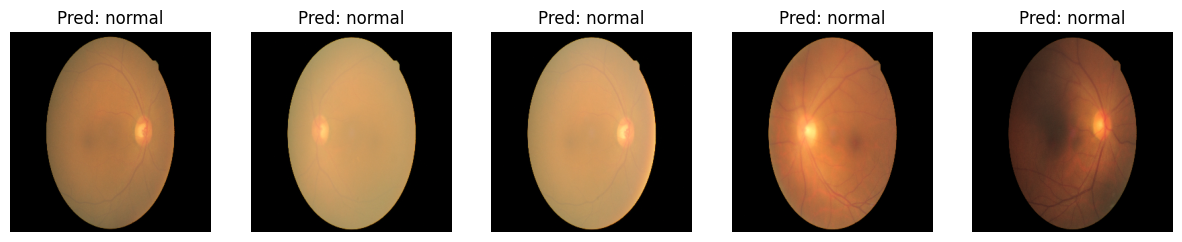

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

# Define the path to the test directory
test_dir = '/content/repository/yiweichen04-retina_dataset-914b0f4/test'

# Adjust the input size to 299x299 to match InceptionV3's input requirements
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(299, 299), batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Predict the test data
predictions = inception_model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Define a function to visualize a few test images along with their predictions
def visualize_predictions(test_gen, y_pred, n=5):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img_path = test_gen.filepaths[i]
        img = image.load_img(img_path, target_size=(299, 299))
        img = image.img_to_array(img)
        img /= 255.0
        plt.imshow(img)
        plt.title(f"Pred: {list(test_gen.class_indices.keys())[y_pred[i]]}")
        plt.axis('off')
    plt.show()

# Visualize predictions for the first n test images
visualize_predictions(test_gen, y_pred, n=5)


# CLASSIFICATION REPORT , CONFUSION MATRIX , ACCURACY CURVES

Classification Report:
              precision    recall  f1-score   support

    cataract       0.00      0.00      0.00        10
      normal       0.75      1.00      0.86        30

    accuracy                           0.75        40
   macro avg       0.38      0.50      0.43        40
weighted avg       0.56      0.75      0.64        40

Confusion Matrix:
[[ 0 10]
 [ 0 30]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


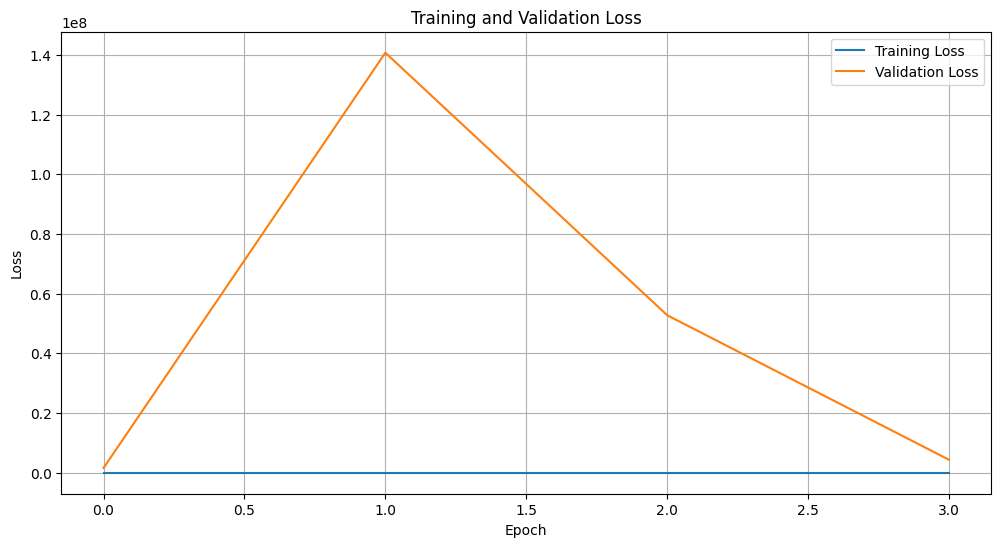

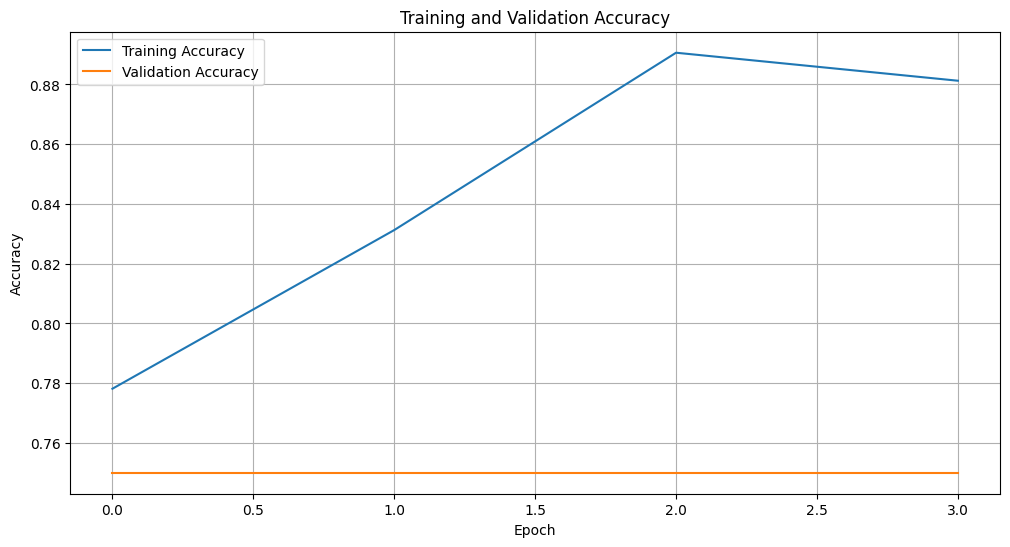

In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plotting loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()